# Transfer Learning with TensorFlow 

# Part 1 Feature Extraction

Transfer Learning is leveraging a working models existing arch and learned patterns for our own problems



There are 2 main benefits:
1. Can leverage an existing NN arch proven to work on problems similar to our own.
2. Can leverage a working NN arch which has already learned patterns on similar data to our own, then we can adapt those patterns to our own data


### Downloading an becoming one with the data

In [1]:
# import tensorflow


import tensorflow as tf

import tensorflow_hub as hub
#import tensorflow_probability as tfp
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator



import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

print(tf.__version__)



# note: to install and import tensorflow_hub, you need to degrade tf-estimator to 2.3.0.... 
# !pip install --upgrade tensorflow-estimator==2.3.0 
# !pip install --upgrade tensorflow-hub

2.3.0


In [2]:
from tensorflow.keras.callbacks import TensorBoard

In [3]:
# get data (10% of 10 food classed from food101)

import zipfile



# download the data

# !wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent


# unzip our data

zip_ref = zipfile.ZipFile(r"D:\Data Science Course details\Udemy_dataset\10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()



In [4]:
# how many image in each folder ?

import os


# walk through 10 percent data directory and list number of files

 
for dirpath, dirnames, filenames in os.walk(r'D:\Data Science Course details\Udemy_dataset\10_food_classes_10_percent\10_food_classes_10_percent'):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")    
    

There are 2 directories and 0 images in 'D:\Data Science Course details\Udemy_dataset\10_food_classes_10_percent\10_food_classes_10_percent'.
There are 10 directories and 0 images in 'D:\Data Science Course details\Udemy_dataset\10_food_classes_10_percent\10_food_classes_10_percent\test'.
There are 0 directories and 250 images in 'D:\Data Science Course details\Udemy_dataset\10_food_classes_10_percent\10_food_classes_10_percent\test\chicken_curry'.
There are 0 directories and 250 images in 'D:\Data Science Course details\Udemy_dataset\10_food_classes_10_percent\10_food_classes_10_percent\test\chicken_wings'.
There are 0 directories and 250 images in 'D:\Data Science Course details\Udemy_dataset\10_food_classes_10_percent\10_food_classes_10_percent\test\fried_rice'.
There are 0 directories and 250 images in 'D:\Data Science Course details\Udemy_dataset\10_food_classes_10_percent\10_food_classes_10_percent\test\grilled_salmon'.
There are 0 directories and 250 images in 'D:\Data Science C

### Creating data loaders (preparing the data)

We'll use ImageDataGenerator class to load in our images in batches



In [5]:
# setup data inputs

from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32


train_dir = r'D:\Data Science Course details\Udemy_dataset\10_food_classes_10_percent\10_food_classes_10_percent\train/'

test_dir = r'D:\Data Science Course details\Udemy_dataset\10_food_classes_10_percent\10_food_classes_10_percent\test/'


train_datagen = ImageDataGenerator(rescale= 1/255.)
test_datagen = ImageDataGenerator(rescale= 1/255.)


print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data = train_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")


Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up Callbacks

(Things to run whilst our model trains)


Callbacks are extra functionality you can add to your models to be performed during or after training. some of the most popular callbacks:

1. Tracking experiments with the tensorboard callback
2. Model checkpoint with the modelCheckpoint callback
3. Stopping a model from training (before it rains too long and overfits) with the earlystopping callback

In [6]:
# create TensorBoard Callback (functionized because we need to create a new one for each model)

import datetime
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback


In [7]:

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

## Creating models using Tensorflow Hub


In the past we've used TF to create our own models layer-by-layer from scratch.


Now we're going to do a similar process, except the majority layers are going to come from Tensorflow Hub.

We can access pretrained model on https://tfhub.dev/

Browsing the Tensorflow HUB page and sorting for image classification, we found the following feature vector model link -   https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1


In [8]:
# lets compare the following two models

# Resnet 50 V2 feature vector
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

# Original: EfficientNetB0 feature vector (version 1)
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

# # New: EfficientNetB0 feature vector (version 2)
# efficientnet_url = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet1k_b0/feature_vector/2"



In [17]:
# import dependencies 

# import tensorflow_hub as hub
# from tensorflow.keras import layers

In [9]:
# lets  make a create_model() function to create a model from a URL

def create_model(model_url, num_classes=10):
  """Takes a TensorFlow Hub URL and creates a Keras Sequential model with it.
  
  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in output layer,
      should be equal to number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the underlying patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape
  
  # Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer, # use the feature extraction layer as the base
    layers.Dense(num_classes, activation='softmax', name='output_layer') # create our own output layer      
  ])

  return model

### Creating and testing ResNet Tensorflow Hub Feature extraction model

In [10]:
# create resnet model

# Create model
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module 'gast' has no attribute 'Index'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [11]:
# compile our resnet model

resnet_model.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=['accuracy'])


In [15]:
 # letd fit our Resnet model to the data (10 percent of 10 classes)


    

resnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch =len(train_data_10_percent),
                                  validation_data= test_data,
                                  validation_steps=len(test_data),
                                  callbacks = [create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                          experiment_name='resnet50V2')])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20210923-175656
Epoch 1/5
 2/24 [=>............................] - ETA: 53s - loss: 1.1471 - accuracy: 0.6087WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 1.2989s vs `on_train_batch_end` time: 3.6016s). Check your callbacks.


24/24 [==============================] - 321s 13s/step - loss: 0.9750 - accuracy: 0.7013 - val_loss: 0.8872 - val_accuracy: 0.7160
Epoch 2/5
24/24 [==============================] - 316s 13s/step - loss: 0.6598 - accuracy: 0.8093 - val_loss: 0.7594 - val_accuracy: 0.7544
Epoch 3/5
24/24 [==============================] - 344s 14s/step - loss: 0.5067 - accuracy: 0.8760 - val_loss: 0.7124 - val_accuracy: 0.7684
Epoch 4/5
24/24 [==============================] - 329s 14s/step - loss: 0.3957 - accuracy: 0.9107 - val_loss: 0.6793 - val_accuracy: 0.7756
Epoch 5/5
24/24 [==============================] - 342s 14s/step - loss: 0.3273 - accuracy: 0.9373 - val_loss: 0.6588 - val_accuracy: 0.7832


In [16]:
# lets create a fun to plot our loss curves


def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))   # how many epochs did we run for ?
    
    
    # plot loss
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()
    
    
    
    # plot the accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

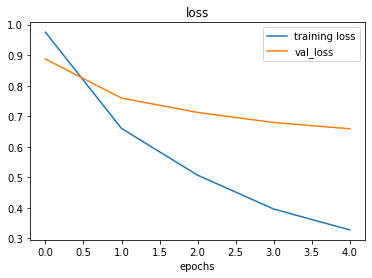

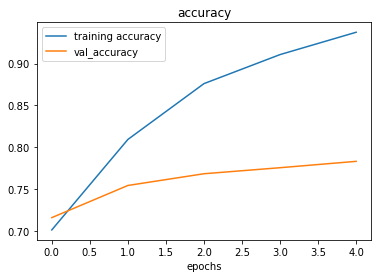

In [17]:
plot_loss_curves(resnet_history)

### Creating and testing EfficientNetB0 TensorFlow Hub Feauture Extraction model 

In [20]:
# create efficientnetB0 feature extractor model

efficientnet_model = create_model(model_url= efficientnet_url, 
                               num_classes=train_data_10_percent.num_classes)








In [21]:
# compile efficientnet model
efficientnet_model.compile(loss='categorical_crossentropy',
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=['accuracy'])


In [22]:
# fit efficientnet model to 10% of training data

efficientnet_history = efficientnet_model.fit(train_data_10_percent,
                                             epochs = 5,
                                             steps_per_epoch= len(train_data_10_percent),
                                             validation_data = test_data,
                                             validation_steps=len(test_data),
                                             callbacks=[create_tensorboard_callback(dir_name = 'tensorflow_hub',
                                                                          experiment_name='EfficentnetB0')])

Saving TensorBoard log files to: tensorflow_hub/EfficentnetB0/20210923-191415
Epoch 1/5
 2/24 [=>............................] - ETA: 3:34 - loss: 2.3822 - accuracy: 0.0625WARNING:tensorflow:Callbacks method `on_train_batch_end` is slow compared to the batch time (batch time: 2.2557s vs `on_train_batch_end` time: 17.1943s). Check your callbacks.


24/24 [==============================] - 265s 11s/step - loss: 1.8418 - accuracy: 0.4387 - val_loss: 1.2929 - val_accuracy: 0.7192
Epoch 2/5
24/24 [==============================] - 271s 11s/step - loss: 1.0754 - accuracy: 0.7440 - val_loss: 0.8677 - val_accuracy: 0.8132
Epoch 3/5
24/24 [==============================] - 248s 10s/step - loss: 0.7686 - accuracy: 0.8293 - val_loss: 0.6942 - val_accuracy: 0.8432
Epoch 4/5
24/24 [==============================] - 243s 10s/step - loss: 0.6133 - accuracy: 0.8653 - val_loss: 0.6092 - val_accuracy: 0.8536
Epoch 5/5
24/24 [==============================] - 247s 10s/step - loss: 0.5179 - accuracy: 0.8973 - val_loss: 0.5531 - val_accuracy: 0.8604


In [23]:
# lets create a fun to plot our loss curves


def plot_loss_curves(history):
    """
    Returns separate loss curves for training and validation metrics
    """
    loss=history.history['loss']
    val_loss=history.history['val_loss']
    
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    
    epochs = range(len(history.history['loss']))   # how many epochs did we run for ?
    
    
    # plot loss
    plt.plot(epochs, loss, label='training loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('loss')
    plt.xlabel('epochs')
    plt.legend()
    
    
    
    # plot the accuracy
    plt.figure()
    plt.plot(epochs, accuracy, label='training accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('accuracy')
    plt.xlabel('epochs')
    plt.legend()

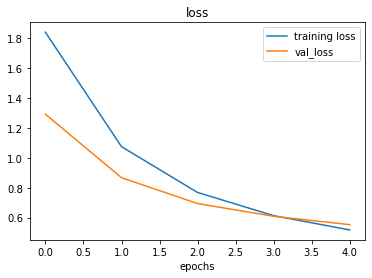

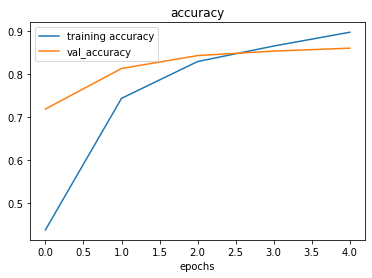

In [24]:
plot_loss_curves(efficientnet_history)

In [25]:
# how many layers does our efficientnet feature extractor have ?

len(efficientnet_model.layers[0].weights)

309

## Different types of Transfer learning


1. As in Transfer learning - using an existing model with no changes whatsover (eg: using ImageNet model on 1000 imagenet  classes, none of our own)

2. Feature Extraction Transfer learning - use the prelearned of an existing model (eg: efficientNetB0 trained on ImageNet) and adjust the output layer for your own problem (eg: 1000 classes --> 10 classes of food)

3. Fine-tuning transfer learning - use the prelearned patterns of an existing model and fine-tune many or all of the underlying layers (including new output layers)